<a href="https://colab.research.google.com/github/kridtapon/WFO-New-Consolidation-Reversal-System/blob/main/WFO_New_Consolidation_Reversal_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install vectorbt

Streaming output truncated to the last 5000 lines.
<ipython-input-8-5cb2c9356e2a>:51: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-8-5cb2c9356e2a>:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-8-5cb2c9356e2a>:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#return


Walk-Forward Optimization Results:
   Year                 Best_Params  Test_Return
0  2020     (5, 5, 15, 7, 0.4, 0.8)     0.394977
1  2021     (5, 5, 15, 9, 0.4, 0.7)     0.181751
2  2022   (7, 11, 15, 13, 0.4, 0.8)     0.145446
3  2023    (21, 5, 15, 5, 0.3, 0.7)     0.123727
4  2024  (27, 19, 17, 13, 0.4, 0.8)     0.989961
5  2025    (9, 19, 15, 7, 0.4, 0.9)     0.000000
Start                         2020-01-02 00:00:00
End                           2024-12-31 00:00:00
Period                                       1258
Start Value                              100000.0
End Value                           594482.413015
Total Return [%]                       494.482413
Benchmark Return [%]                   676.280076
Max Gross Exposure [%]                      100.0
Total Fees Paid                       5657.688892
Max Drawdown [%]                        38.866525
Max Drawdown Duration                       318.0
Total Trades                                   12
Total Closed Trades  

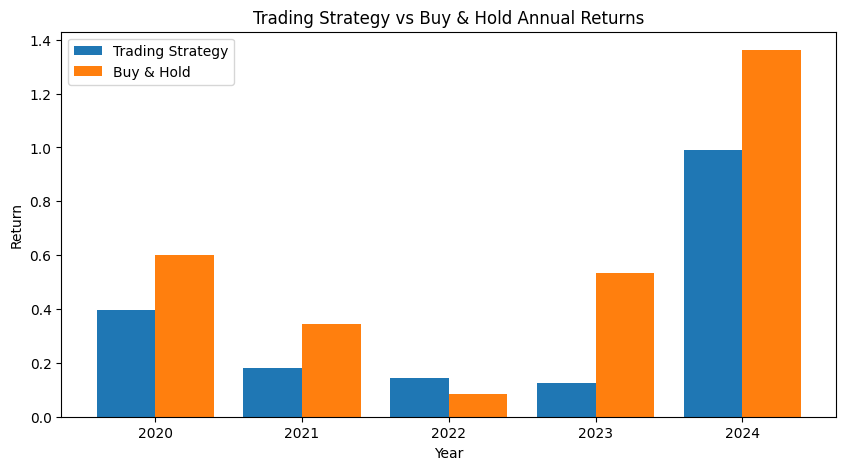

In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
import vectorbt as vbt
import matplotlib.pyplot as plt
import itertools

# Function to calculate Gopalakrishnan Range Index (GAPO)
def calculate_gapo(df, period=14):
    df['Range'] = df['High'] - df['Low']
    df['GAPO'] = (df['Range'].rolling(window=period).sum()) / (df['High'].rolling(window=period).sum() + df['Low'].rolling(window=period).sum())
    return df

# Function to calculate MACD and Signal Line
def calculate_macd(df, fast_period=12, slow_period=26, signal_period=9):
    macd = df['Close'].ewm(span=fast_period, adjust=False).mean() - df['Close'].ewm(span=slow_period, adjust=False).mean()
    macd_signal = macd.ewm(span=signal_period, adjust=False).mean()
    return macd, macd_signal

# Function to perform walk-forward optimization with GAPO and MACD
def walk_forward_optimization_gapo_macd(df, start_year, end_year):
    results = []

    # Define dynamic ranges for GAPO and MACD parameters
    gapo_period_range = range(5, 31, 2)
    macd_fast_period_range = range(5, 21, 2)
    macd_slow_period_range = range(15, 31, 2)
    macd_signal_period_range = range(5, 15, 2)
    gapo_entry_quantile_range = [0.1, 0.2, 0.3, 0.4]
    gapo_exit_quantile_range = [0.6, 0.7, 0.8, 0.9]

    for test_year in range(start_year + 4, end_year + 1):
        train_start = test_year - 4
        train_end = test_year - 1
        test_start = test_year

        train_data = df[(df.index.year >= train_start) & (df.index.year <= train_end)]
        test_data = df[df.index.year == test_year]

        best_params = None
        best_performance = -np.inf

        # Loop through all combinations of GAPO and MACD parameters
        for params in itertools.product(gapo_period_range, macd_fast_period_range, macd_slow_period_range, macd_signal_period_range, gapo_entry_quantile_range, gapo_exit_quantile_range):
            gapo_period, macd_fast_period, macd_slow_period, macd_signal_period, gapo_entry_quantile, gapo_exit_quantile = params

            # Calculate GAPO
            train_data = calculate_gapo(train_data, gapo_period)

            # Calculate MACD
            train_data['MACD'], train_data['MACD_Signal'] = calculate_macd(train_data, macd_fast_period, macd_slow_period, macd_signal_period)

            # Generate entry and exit signals based on GAPO and MACD
            entries = (train_data['GAPO'] < train_data['GAPO'].quantile(gapo_entry_quantile)) & (train_data['MACD'] > train_data['MACD_Signal'])
            exits = (train_data['GAPO'] > train_data['GAPO'].quantile(gapo_exit_quantile)) & (train_data['MACD'] < train_data['MACD_Signal'])

            # Backtest on training data
            portfolio = vbt.Portfolio.from_signals(
                close=train_data['Close'],
                entries=entries,
                exits=exits,
                init_cash=100_000,
                fees=0.001
            )

            performance = portfolio.total_return()
            if performance > best_performance:
                best_performance = performance
                best_params = (gapo_period, macd_fast_period, macd_slow_period, macd_signal_period, gapo_entry_quantile, gapo_exit_quantile)

        # Test with the best parameters on the test data
        yearly_data = df[(df.index.year >= test_year - 1) & (df.index.year <= test_year)]

        # Apply GAPO and MACD indicators
        yearly_data = calculate_gapo(yearly_data, best_params[0])
        yearly_data['MACD'], yearly_data['MACD_Signal'] = calculate_macd(yearly_data, best_params[1], best_params[2], best_params[3])

        # Keep only the second year to avoid missing values from indicator calculation
        yearly_data = yearly_data[yearly_data.index.year == test_year]

        # Define entry/exit conditions
        entries = (yearly_data['GAPO'] < yearly_data['GAPO'].quantile(best_params[4])) & (yearly_data['MACD'] > yearly_data['MACD_Signal'])
        exits = (yearly_data['GAPO'] > yearly_data['GAPO'].quantile(best_params[5])) & (yearly_data['MACD'] < yearly_data['MACD_Signal'])

        portfolio = vbt.Portfolio.from_signals(
            close=yearly_data['Close'],
            entries=entries,
            exits=exits,
            init_cash=100_000,
            fees=0.001
        )

        results.append({
            'Year': test_year,
            'Best_Params': best_params,
            'Test_Return': portfolio.total_return()
        })

    return pd.DataFrame(results)

# Define the stock symbol and time period
symbol = 'AXON'  #
start_date = '2015-01-01'
end_date = '2025-01-01'

# Download the stock data
df = yf.download(symbol, start=start_date, end=end_date)
df.columns = ['Close', 'High', 'Low', 'Open', 'Volume']
df.ffill(inplace=True)

# Perform walk-forward optimization with GAPO and MACD
results = walk_forward_optimization_gapo_macd(df, 2016, 2025)

# Display results
print("\nWalk-Forward Optimization Results:")
print(results)

# Combine signals into a single portfolio
combined_entries = pd.Series(False, index=df.index)
combined_exits = pd.Series(False, index=df.index)

for _, row in results.iterrows():
    year = row['Year']
    params = row['Best_Params']

    # Extend the data range to include the previous year for indicator calculation
    yearly_data = df[(df.index.year >= year - 1) & (df.index.year <= year)]

    # Apply GAPO and MACD indicators
    yearly_data = calculate_gapo(yearly_data, params[0])
    yearly_data['MACD'], yearly_data['MACD_Signal'] = calculate_macd(yearly_data, params[1], params[2], params[3])

    # Keep only the second year to avoid missing values from indicator calculation
    yearly_data = yearly_data[yearly_data.index.year == year]

    # Define entry/exit conditions
    entries = (yearly_data['GAPO'] < yearly_data['GAPO'].quantile(params[4])) & (yearly_data['MACD'] > yearly_data['MACD_Signal'])
    exits = (yearly_data['GAPO'] > yearly_data['GAPO'].quantile(params[5])) & (yearly_data['MACD'] < yearly_data['MACD_Signal'])

    combined_entries.loc[entries.index] = entries
    combined_exits.loc[exits.index] = exits

# Filter data for testing period only
df = df[(df.index.year >= 2020) & (df.index.year <= 2025)]
combined_entries = combined_entries[(combined_entries.index.year >= 2020) & (combined_entries.index.year <= 2025)]
combined_exits = combined_exits[(combined_exits.index.year >= 2020) & (combined_exits.index.year <= 2025)]

# Backtest using the combined signals
portfolio = vbt.Portfolio.from_signals(
    close=df['Close'],
    entries=combined_entries,
    exits=combined_exits,
    init_cash=100_000,
    fees=0.001
)

# Display performance metrics
print(portfolio.stats())

# Plot equity curve
portfolio.plot().show()

# Get unique years in the dataset
years = sorted(df.index.year.unique())

# Store annual returns
strategy_returns = {}
buy_and_hold_returns = {}

for year in years:
    yearly_data = df[df.index.year == year]

    if not yearly_data.empty:  # Check if data exists for the year
        # Buy & Hold Return
        start_price = yearly_data.iloc[0]['Close']
        end_price = yearly_data.iloc[-1]['Close']
        buy_and_hold_return = (end_price - start_price) / start_price
        buy_and_hold_returns[year] = buy_and_hold_return

        # Strategy Return
        strategy_returns[year] = results[results['Year'] == year]['Test_Return'].values[0]

# Plot bar chart
plt.figure(figsize=(10, 5))
bar_width = 0.4
plt.bar([y - bar_width/2 for y in strategy_returns.keys()], strategy_returns.values(), width=bar_width, label="Trading Strategy")
plt.bar([y + bar_width/2 for y in buy_and_hold_returns.keys()], buy_and_hold_returns.values(), width=bar_width, label="Buy & Hold")

plt.xlabel("Year")
plt.ylabel("Return")
plt.title("Trading Strategy vs Buy & Hold Annual Returns")
plt.legend()
plt.xticks(list(strategy_returns.keys()))

plt.show()


In [ ]:
# Filter Test Years
df = df[(df.index.year >= 2020) & (df.index.year <= 2025)]

# Buy and Hold Performance Metrics
df_holding = df['Close']
pf = vbt.Portfolio.from_holding(df_holding, init_cash=100_000)
pf.stats()

/usr/local/lib/python3.11/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'sharpe_ratio' requires frequency to be set

/usr/local/lib/python3.11/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'calmar_ratio' requires frequency to be set

/usr/local/lib/python3.11/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'omega_ratio' requires frequency to be set

/usr/local/lib/python3.11/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'sortino_ratio' requires frequency to be set



,Close
Start,2020-01-02 00:00:00
End,2024-12-31 00:00:00
Period,1258
Start Value,100000.0
End Value,776280.076119
Total Return [%],676.280076
Benchmark Return [%],676.280076
Max Gross Exposure [%],100.0
Total Fees Paid,0.0
Max Drawdown [%],58.542575
